# 1 практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Проничкин Юрий Викторович

**Дедлайн**: 29 сентября 2020

In [1]:
import numpy as np

# Реализация нейронной сети (15 баллов)
В этом задании вы обучите полносвязную нейронную сеть распознавать рукописные цифры, [почти] самостоятельно реализовав все составляющие алгоритма обучения и предсказания.

Для начала нам понадобится реализовать прямой и обратный проход через слои. Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

In [2]:
class IdentityLayer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           
    output = layer.forward(input)
    
    - Propagate gradients through itself:    
    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters.
    
    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) 
        and auxiliary stuff. You should enumerate all parameters
        in self.params"""
        # An identity layer does nothing
        self.params = []
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], 
        returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        self.input = input
        return input

    def backward(self, grad_output): 
        """
        Performs a backpropagation step through the layer, 
        with respect to the given input.
        
        To compute loss gradients w.r.t input, 
        you need to apply chain rule (backprop):
        
        d loss / d input  = (d loss / d layer) *  (d layer / d input)
        
        Luckily, you already receive d loss / d layer as input, 
        so you only need to multiply it by d layer / d x.
        
        The method returns:
        * gradient w.r.t input (will be passed to 
          previous layer's backward method)
        * flattened gradient w.r.t. parameters (with .ravel() 
          applied to each gradient). 
          If there are no params, return []
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = self.input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input), [] # chain rule


# Слой нелинейности ReLU
Для начала реализуем слой нелинейности $ReLU(x) = max(x, 0)$. Параметров у слоя нет. Метод forward должен вернуть результат поэлементного применения ReLU к входному массиву, метод backward - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить как атрибут класса.

In [3]:
class ReLU:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        self.params = [] # ReLU has no parameters
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, num_units] matrix"""
        self.ins = (input <= 0)
        ret = np.copy(input)
        ret[self.ins] = 0
        return ret
        
    
    def backward(self, grad_output):
        """Compute gradient of loss w.r.t. ReLU input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        out = np.ones(grad_output.shape)
        out[self.ins] = 0
        return out * grad_output, []

# Полносвязный слой
Далее реализуем полносвязный слой без нелинейности. У слоя два параметра: матрица весов и вектор сдвига.

Обратите внимание на второй аргумент: в нем надо возвращать градиент по всем параметрам в одномерном виде. Для этого надо сначала применить .ravel() ко всем градиентам, а затем воспользоваться np.r_:

In [4]:
class Dense:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self, input_units, output_units):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = W x + b
        """
        # initialize weights with small random numbers from normal distribution
        weights = np.random.randn(output_units, input_units) * 0.01
        biases = np.zeros(output_units)
        self.w_shape = weights.shape
        self.params = [weights.ravel(), biases]
        
    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = W x + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        self.ins = input
        return (self.params[0].reshape(self.w_shape) @ input.T).T +\
                                                                 self.params[1]
        
    
    def backward(self, grad_output):
        """
        compute gradients
        grad_output shape: [batch, output_units]
        output shapes: [batch, input_units], [num_params]
        
        hint: use function np.r_
        np.r_[np.arange(3), np.arange(3)] = [0, 1, 2, 0, 1, 2]
        """
        return (self.params[0].reshape(self.w_shape).T @ grad_output.T).T, \
                    np.r_[
                    (grad_output.T @ self.ins ).ravel(),
                    grad_output.sum(axis=0).ravel()
                ]
                                              

# Проверка градиента
Проверим правильность реализации с помощью функции численной проверки градиента. Функция берет на вход callable объект (функцию от одного аргумента-матрицы) и аргумент и вычисляет приближенный градиент функции в этой точке.

In [5]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore
        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

Вычислите аналитический и численный градиенты по входу слоя ReLU от функции$$ f(y) = \sum_i y_i, \quad y = ReLU(x) $$

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [6]:
def funk(x):
    activation = ReLU()
    return activation.forward(x).sum()

In [7]:
activation = ReLU()
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
numeric_grads = eval_numerical_gradient(funk, points, False)
activation.forward(points)
grads = activation.backward(np.ones_like(points))

assert np.allclose(grads[0], numeric_grads, rtol=1e-3, atol=0)

Вычислите аналитический и численный градиенты по входу полносвязного слоя от функции$$ f(y) = \sum_i y_i, \quad y = W x + b $$

In [8]:
class fun:
    def __init__(self, dense):
        self.dense = dense

    def frw(self, x):
        return self.dense.forward(x).sum()

In [9]:
x = np.linspace(-1, 1, 10*12).reshape([10, 12])
l = Dense(12, 32)
f = fun(l)
### your code here
l.forward(x)
grads = l.backward(np.ones((10, 32)))
numeric_grads = eval_numerical_gradient(f.frw, x, verbose=False, h=0.00001)
assert np.allclose(grads[0], numeric_grads, rtol=1e-3, atol=0)

In [10]:
class fun2:
    def __init__(self, dense, w):
        self.dense = dense
        self.x = w

    def frw(self, x):
        self.dense.params[0] = x
        return self.dense.forward(self.x).sum()

In [11]:
x = np.linspace(-1, 1, 2*12).reshape([12, 2])
l = Dense(2, 3)
w = l.params[0]
l.forward(x)
f = fun2(l, x)
grads = l.backward(np.ones((12, 3)))
numeric_grads = eval_numerical_gradient(f.frw, w, verbose=False, h=0.00001)
assert np.allclose(grads[1][:6], numeric_grads, rtol=1e-3, atol=0)

# Softmax

Реализация softmax-слоя и функции потерь
Для решения задачи многоклассовой классификации обычно используют softmax в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой Softmax (без параметров). Метод forward должен вычислять логарифм от softmax, а метод backward - пропускать градиенты. В общем случае в промежуточных вычислениях backward получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент grad_output - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

In [12]:
from scipy.special import logsumexp
from scipy.special import softmax
# use this function instead of np.log(np.sum(np.exp(...))) !
# because it is more stable

In [13]:
class Softmax:
    def __init__(self):
        self.params = []
        
    def forward(self, input):
        """
        Applies softmax to each row and then applies component-wise log
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        """
        self.ins = input
        return input - logsumexp(input, axis=1).reshape(-1, 1)
        
    
    def backward(self, grad_output):
        """
        Propagartes gradients.
        Assumes that each row of grad_output contains only 1 
        non-zero element
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        Do not forget to return [] as second value (grad w.r.t. params)
        """
        return grad_output - softmax(self.ins, axis=1) * \
                                    grad_output.sum(axis=1).reshape(-1, 1) , []

# Dropout
Реализуйте слой Dropout. Сравните обучение сети из большого числа слоёв при использовании Dropout и без его использования (предварительно подберите адекватный параметр p). Сделайте выводы. Используя метод оптимизации из первого бонусного пункта.

In [14]:
class Dropout:
    def __init__(self, p):
        self.params = []
        self.p = p
        
    def forward(self, input):
        """
        Randomly  drops connections between nurons.
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        """
        self.drops = np.random.binomial(np.ones_like(input), self.p)
        return input * self.drops
        
    
    def backward(self, grad_output):
        """
        Propagartes gradients.
        Assumes that each row of grad_output contains only 1 
        non-zero element
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        Do not forget to return [] as second value (grad w.r.t. params)
        """
        return grad_output * self.drops, []

Реализуйте функцию потерь и градиенты функции потерь.

In [15]:
def crossentropy(activations, target):
    """
    returns negative log-likelihood of target under model represented by
    activations (log probabilities of classes)
    each arg has shape [batch, num_classes]
    output shape: 1 (scalar)
    """
    return -1 * (target * activations).sum() / target.shape[0]
    

def grad_crossentropy(activations, target):
    """
    returns gradient of negative log-likelihood w.r.t. activations
    each arg has shape [batch, num_classes]
    output shape: [batch, num-classes]
    
    hint: this is just one-hot encoding of target vector
          multiplied by -1
    """
    return -1 * target / target.shape[0]

Наконец, выполните проверку softmax-слоя, используя функцию потерь и ее градиент.

In [16]:
def f_3(x):
    targ = np.zeros((10 , 12))
    for i in range(10):
        targ[i][i] = 1
    sm = Softmax()
    return crossentropy(sm.forward(x), targ)

In [17]:
targ = np.zeros((10 , 12))
for i in range(10):
    targ[i][i] = 1

In [18]:
x = np.linspace(-1, 1, 10*12).reshape([10, 12])
sm = Softmax()
grads = sm.backward(grad_crossentropy(sm.forward(x), targ))
numeric_grads = eval_numerical_gradient(f_3, x, verbose=False, h=0.00001)
assert np.allclose(grads[0], numeric_grads, rtol=1e-3, atol=0)

# Загрузка данных
Мы реализаовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом digits, каждый объект в котором - это 8x8 изображение рукописной цифры.

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
from sklearn.datasets import load_digits

In [21]:
X, y = load_digits(return_X_y=True)

In [22]:
tmp = np.zeros((y.size, y.max()+1))
tmp[np.arange(y.size), y] = 1
y = tmp

2


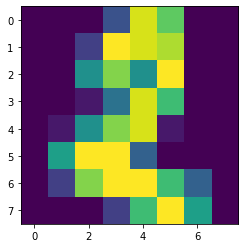

In [23]:
plt.imshow(X[2].reshape(8,-1))
print(np.argmax(y[2]))

In [24]:
X.shape, y.shape

((1797, 64), (1797, 10))

Разделим данные на обучение и контроль:

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [27]:
X_train.shape, X_test.shape

((1347, 64), (450, 64))

# Сборка и обучение нейронной сети (5 балла)

В нашей реализации нейросеть - это список слоев. Например:

In [28]:
#@title
network = []
hidden_layers_size = 32
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))
network.append(Softmax())

Для проверки, хорошо ли сеть обучилась, нам понадобится вычислять точность (accuracy) на данной выборке. Для этого реализуйте функцию, которая делает предсказания на каждом объекте:

In [29]:
def predict(network, X):
    """
    returns predictions for each object in X
    network: list of layers
    X: raw data
    X shape: [batch, features_num]
    output: array of classes, each from 0 to 9
    output shape: [batch]
    """
    for layer in network:
        X = layer.forward(X)
    return np.argmax(X, axis=1)

Мы будем обучать параметры нейросети с помощью готовой функции оптимизации из модуля scipy:

In [30]:
from scipy.optimize import minimize

In [ ]:
help(minimize)


Эта функция имеет стандартный интерфейс: нужно передать callable объект, который вычисляет значение и градиент целевой функции, а также точку старта оптимизации - начальное приближение (одномерный numpy-массив). Поэтому нам понадобятся функции для сбора и задания всех весов нашей нейросети (именно для них мы всегда записывали параметры слоя в список layer.params)

In [31]:
def get_weights(network):
    weights = []
    for layer in network:
        for param in layer.params:
            weights += param.ravel().tolist()
    return np.array(weights)

def set_weights(weights, network):
    i = 0
    for layer in network:
        for param in layer.params:
            l = param.size
            param[:] = weights[i:i+l].\
                             reshape(param.shape)
            i += l

Вам нужно реализовать ту самую функцию, которую мы будем передавать в minimize. Эта функция должна брать на вход текущую точку (вектор всех параметров), а также список дополнительных параметров (мы будем передавать через них нашу сеть и обучающие данные) и возвращать значение критерия качества (кросс-энтропия) и его градиент по параметрам модели.

In [32]:
def compute_loss_grad(weights, args):
    """
    takes current weights and computes cross-entropy and gradients
    weights shape: [num_parameters]
    output 1: loss (scalar)
    output 2: gradint w.r.t. weights, shape: [num_parameters]
    
    hint: firstly perform forward pass through the whole network
    then compute loss and its gradients
    then perform backward pass, transmitting first baskward output
    to the previos layer and saving second baskward output in a list
    finally flatten all the gradients in this list
    (in the order from the first to the last layer)
    
    Do not forget to set weights of the network!
    """
    network, X, y = args
    f_weights = get_weights(network)
    set_weights(weights, network)
    weights_grad = np.zeros_like(weights)
    layers_boards = []
    l = 0
    for layer in network:
        X = layer.forward(X)
        if len(layer.params) > 0:
            l_new = l + len(layer.params[0]) + len(layer.params[1])
            layers_boards.append((l, l_new))
            l = l_new
    loss = crossentropy(X, y)
    loss_grad = grad_crossentropy(X, y)
    i = -1
    for layer in network[::-1]:
        loss_grad, curr_grad = layer.backward(loss_grad)
        if len(curr_grad) > 0:
            weights_grad[layers_boards[i][0] : layers_boards[i][1]] = \
                curr_grad
            i -= 1
    return loss, weights_grad

Теперь мы готовы обучать нашу нейросеть.

In [33]:
weights = get_weights(network)

In [34]:
res = minimize(compute_loss_grad, weights,  # fun and start point
               args=[network, X_train, y_train], # args passed to fun
               method="L-BFGS-B", # optimization method
               jac=True) # says that gradient are computed in fun

In [35]:
res.keys()

dict_keys(['fun', 'jac', 'nfev', 'nit', 'status', 'message', 'x', 'success', 'hess_inv'])

In [36]:
res["nit"] # number of iterations (should be >> 10)

106

In [37]:
res["success"] # should be True

True

In [38]:
res["x"] # leraned weights

array([ 1.02889740e-03,  1.82812902e-02,  9.11677428e-02, ...,
       -6.61873190e-01, -1.61014206e+00, -3.44444256e-01])

Выведите качество на обучении (X_train, y_train) и на контроле (X_test, y_test. Не забудьте установить веса!

In [39]:
set_weights(res['x'], network)

In [40]:
(predict(network, X_test) == np.argmax(y_test, axis=1)).sum() / y_test.shape[0]

0.96

У minimize есть также аргумент callback - в нее можно передать функцию, которая будет вызываться после каждой итерации оптимизации. Такую функцию удобно оформить в виде метода класса, который будет сохранять качество на обучении контроле после каждой итерации. Реализуйте этот метод в классе Callback:

In [41]:
class Callback:
    def __init__(self, network, X_train, y_train, X_test, y_test, print=False):
        self.network = network
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.print = print
        self.train_acc = []
        self.test_acc = []
        
    def call(self, weights):
        """
        computes quality on train and test set with given weights
        and saves to self.train_acc and self.test_acc
        if self.print is True, also prints these 2 values
        """
        set_weights(weights, self.network)
        self.test_acc.append(
             ( 
                predict(self.network, self.X_test) == \
                np.argmax(self.y_test, axis=1)
             ).sum() / self.y_test.shape[0]
                            )
        self.train_acc.append(
             ( 
                predict(self.network, self.X_train) == \
                np.argmax(self.y_train, axis=1)
             ).sum() / self.y_train.shape[0]
                            )
        if self.print:
            print('Train : {0} Test {1}'.format(self.train_acc[-1],
                                                self.test_acc[-1]))

In [42]:
cb = Callback(network, X_train, y_train, X_test, y_test, print=True)

In [43]:
res = minimize(compute_loss_grad, weights,  
               args=[network, X_train, y_train], 
               method="L-BFGS-B",
               jac=True,
               callback=cb.call)

Train : 0.10616184112843356 Test 0.08444444444444445
Train : 0.17223459539717892 Test 0.14222222222222222
Train : 0.17297698589458055 Test 0.14222222222222222
Train : 0.1744617668893838 Test 0.14222222222222222
Train : 0.20415738678544915 Test 0.18222222222222223
Train : 0.2301410541945063 Test 0.19777777777777777
Train : 0.37639198218262804 Test 0.36444444444444446
Train : 0.3867854491462509 Test 0.35555555555555557
Train : 0.5055679287305123 Test 0.5266666666666666
Train : 0.5308092056421678 Test 0.5
Train : 0.6124721603563474 Test 0.6066666666666667
Train : 0.6169265033407573 Test 0.5888888888888889
Train : 0.6384558277654045 Test 0.6355555555555555
Train : 0.6837416481069042 Test 0.6733333333333333
Train : 0.7305122494432071 Test 0.6955555555555556
Train : 0.7379361544172235 Test 0.7355555555555555
Train : 0.7594654788418709 Test 0.76
Train : 0.7965850037119525 Test 0.7911111111111111
Train : 0.8210838901262064 Test 0.8022222222222222
Train : 0.8225686711210096 Test 0.8044444444444

Изобразите на графике кривую качества на обучени ии контроле по итерациям:

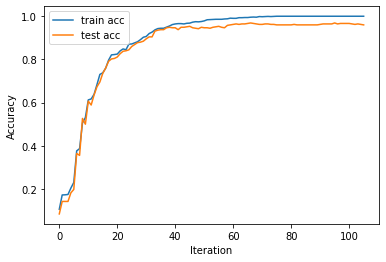

In [44]:
plt.plot(cb.train_acc, label="train acc")
plt.plot(cb.test_acc, label="test acc")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()

Эксперименты с числом слоев (2 балла)

Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучать нашу нейросеть с разным числом слоев несколько раз.

Заполните матрицы accs_train и accs_test. В позиции [i, j] должна стоять величина точности сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны).

In [45]:
accs_test = np.zeros((5, 5))
accs_train = np.zeros((5, 5))

In [46]:
for i in range(5):
    for j in range(5):
        network = []
        hidden_layers_size = 32
        if i == 0:
            network.append(Dense(X_train.shape[1], 10))
            network.append(Softmax())
        elif i == 1:
            network.append(Dense(X_train.shape[1], hidden_layers_size))
            network.append(ReLU())
            network.append(Dense(hidden_layers_size, 10))
            network.append(Softmax())
        else:
            network.append(Dense(X_train.shape[1], hidden_layers_size))
            network.append(ReLU())
            for m in range(i - 1):
                network.append(Dense(hidden_layers_size, hidden_layers_size))
                network.append(ReLU())
            network.append(Dense(hidden_layers_size, 10))
            network.append(Softmax())
        weights = get_weights(network)
        cb = Callback(network, X_train, y_train, X_test, y_test, print=False)
        res = minimize(compute_loss_grad, weights,  
               args=[network, X_train, y_train], 
               method="L-BFGS-B",
               jac=True,
               callback=cb.call)
        accs_test[i, j] = cb.test_acc[-1]
        accs_train[i, j] = cb.train_acc[-1]

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце - среднее, прямоугольник показывает разброс).

In [47]:
accs_test

array([[0.95111111, 0.94444444, 0.94666667, 0.94666667, 0.94666667],
       [0.96      , 0.95333333, 0.93777778, 0.95777778, 0.96666667],
       [0.94222222, 0.95333333, 0.96      , 0.94666667, 0.95777778],
       [0.95333333, 0.95333333, 0.91555556, 0.95555556, 0.92888889],
       [0.93555556, 0.92888889, 0.94      , 0.92222222, 0.95777778]])

In [48]:
accs_train

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

Text(0.5, 1.0, 'Test quality in 5 runs')

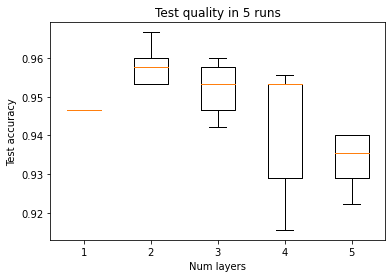

In [49]:
plt.boxplot(accs_test.T, showfliers=False)
plt.xlabel("Num layers")
plt.ylabel("Test accuracy")
plt.title("Test quality in 5 runs")

Ответьте на вопросы (кратко в этой же ячейке):

Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?
Можно ли сказать, что логистическая регрессия (линейная модель) дает качество хуже, чем нелинейная модель?
* Несколько фрагментов кода в задании написаны на основе материалов курса по глубинному обучению на ФКН НИУ ВШЭ

На обучении качество всегда 1 - модель переобучается. При этом более с глубиной сети качество на тесте сначала растет и модель становится более устойчивой к начальному приближению (с 2-3 слоями), а затем качество и устойчивость падают - наверное такие модели слишком сложны для задачи. Т.к. модель с одним слоем и есть  10 логистических регрессий, можно сказать что она дает качество в среднем хуже чем нейросетевые модели с 2 и 3 слоями, при этом она более устойчива к начальному приближению и работает лучше более глубоких моделей.

# Бонусная часть.

## Реализация метода оптимизации (2 балла).
Реализуйте сами метод оптимизации (аналог функции minimize) для рассмотренной выше архитектуры. В качестве метода оптимизации используйте SGD + momentum. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с LBFGS-B. Сделайте выводы.

In [241]:
def SGD_momentum_optizmazer(network,
                            X_train,
                            y_train,
                            X_test,
                            y_test,
                            maxit=10000,
                            tol=1e-5,
                            rho=0.35,
                            learning_rate=0.06):
    loses = []
    accs = []
    weights = get_weights(network)
    moments = np.copy(weights)
    pred_loss = 0
    new_loss = 0
    for it in range(maxit):
        new_loss, grad = compute_loss_grad(weights, [network, X_train, y_train])
        moments = moments * rho + grad
        weights = weights - moments * learning_rate
        if np.abs(new_loss - pred_loss) < tol:
            return new_loss, weights, loses, accs
        pred_loss = new_loss
        loses.append(new_loss)
        set_weights(weights, network)
        accs.append(
                (
                    predict(network, X_test) == np.argmax(y_test, axis=1)
                ).sum() / y_test.shape[0]
            )
    return new_loss, weights, loses, accs

In [277]:
network = []
hidden_layers_size = 32
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))
network.append(Softmax())
loss, weights, loses, accs  = SGD_momentum_optizmazer(network,
                                        X_train,
                                        y_train,
                                        X_test,
                                        y_test,
                                        maxit=500,
                                        tol=1e-6,
                                        rho=0.5,
                                        learning_rate=0.06)

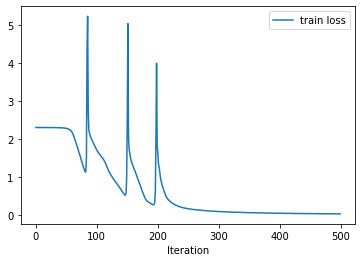

In [278]:
plt.plot(loses, label="train loss")
plt.xlabel("Iteration")
plt.legend()

In [274]:
network = []
hidden_layers_size = 32
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))
network.append(Softmax())
loss, weights, loses, accs  = SGD_momentum_optizmazer(network,
                                        X_train,
                                        y_train,
                                        X_test,
                                        y_test,
                                        maxit=500,
                                        tol=1e-6,
                                        rho=0.1,
                                        learning_rate=0.06)

При меньшем $\rho$ сходимость менее равномерная

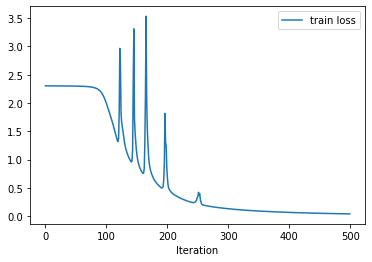

In [275]:
plt.plot(loses, label="train loss")
plt.xlabel("Iteration")
plt.legend()

Резкое увеличение лосса сказывается и на точности

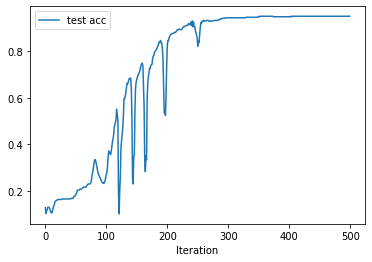

In [276]:
plt.plot(accs, label="test acc")
plt.xlabel("Iteration")
plt.legend()

LBFGS-B сходится быстрее и точнее, чем реализованный метод, при этом после ~250 итераций заметна разница только в loss, а тестовая точность примерно одинаковая.

# 1D Сверточный слой (2 балла).

Сверткой сигнала $\mathbf{x}$ ядром  $\mathbf{k}$ называется переобразование:
$$
 y_i = (\mathbf{x} \circ \mathbf{k})_i = \sum \limits_{j=i-t}^{i+t} x_j \cdot k_{j-i+t}, \; |\mathbf{k}| = 2t + 1
$$

Найти явные формулы для:

$$
\frac{\partial \mathbf y}{\partial \mathbf x}, \; \frac{\partial \mathbf y}{\partial \mathbf k}
$$

Почему использование сверточных слоев может быть вычислительно выгодно в контексте глубинного обучения?

**Замечание**: Требуется привести аналитическое решение (можно не программировать)!


Перепишем в матричном виде, получим:

$$\begin{pmatrix}
y_t \\ 
y_{t + 1} \\ 
...\\ 
...\\
...\\ 
y_{n - t}\\ 
\end{pmatrix}
=
\begin{pmatrix}
 k_1&  k_2& ... & k_t & 0 & ... & 0 & 0 & 0 \\ 
 0 & k_1 & k_2 & ... & k_t & 0 & ... & 0 & 0 \\ 
 0& 0 & k_1 & k_2 & ... & k_t & 0 & ... & 0 \\ 
...& ... & ... & ... & ... & ... & ... & ... & ... & \\ 
...& ... & ... & ... & ... & ... & ... & ... & ... & \\ 
 0 & 0 & 0 & ... & 0 & k_1 & k_2 & ... & k_t \\ 
\end{pmatrix}
\begin{pmatrix}
x_1\\ 
x_2\\ 
x_3\\ 
...\\ 
...\\ 
x_n\\ 
\end{pmatrix} $$

Пусть полученная матрица - $K$ тогда $\frac{\partial \mathbf y}{\partial \mathbf x} = K^T$

Теперь $\frac{\partial \mathbf y_{t+i}}{\partial \mathbf k} = 
\begin{pmatrix}
x_{i + 1}\\ 
x_{i + 2}\\  
...\\ 
...\\ 
x_{i + t}\\ 
\end{pmatrix}$ , $i \in (0, ... n - 2t)$

Тогда $$
\frac{\partial \mathbf y}{\partial \mathbf k} = 
\begin{pmatrix}
 x_1&  x_2& ... & x_{n - 2t + 1}  \\ 
 x_2 & x_3 & ... & x_{n - 2t + 2} \\  
 x_t & x_{t+1} & ... & x_n \\ 
\end{pmatrix}
$$

Т.к. градиенты - матрицы, то пробрасование градиента - перемножение матриц, которое может быть эффективно ускорено с помощью блочного умножения и распараллеливания на GPU.

# Квадратичная форма (4 балла).

Пусть имеется функция:
$$
Q = \mathbf{x}^\top W^\top W \mathbf{x}
$$

Вычислить производные, предложить алгоритм для backpropagation через данное преобразование:
$$
\frac{\partial Q}{\partial \mathbf x}, \; \frac{\partial Q}{\partial W}
$$

**Замечание**: Требуется привести аналитическое решение (можно не программировать)!